In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor


In [3]:
df = pd.read_csv('../data/processed/data110-dataset-cleaned.csv')

print(df.info())
df.head()
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             78 non-null     object 
 1   Region                              78 non-null     object 
 2   antimicrobial_mg_per_population     78 non-null     float64
 3   kilograms_eggs_per_year_per_capita  77 non-null     float64
 4   expected_schooling_years            75 non-null     float64
 5   ibs_rate_2017                       76 non-null     float64
 6   kilograms_meat_per_year_per_capita  77 non-null     float64
 7   kilograms_milk_per_year_per_capita  77 non-null     float64
 8   PercentResistant                    78 non-null     float64
dtypes: float64(7), object(2)
memory usage: 5.6+ KB
None
Country                               0
Region                                0
antimicrobial_mg_per_population       0
kilogr

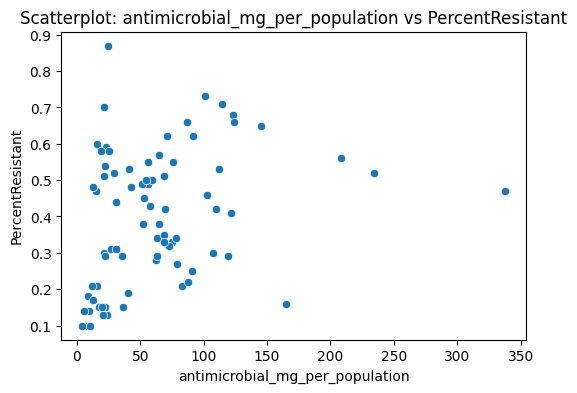

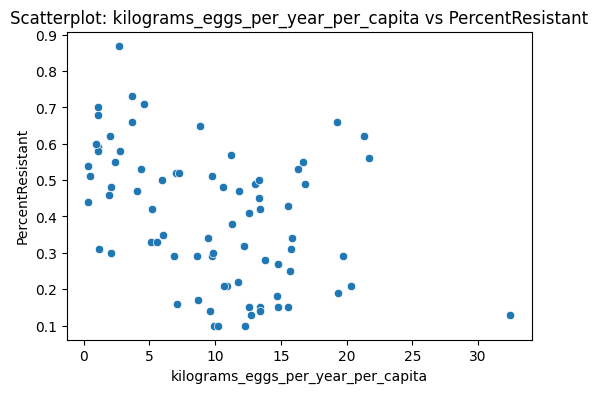

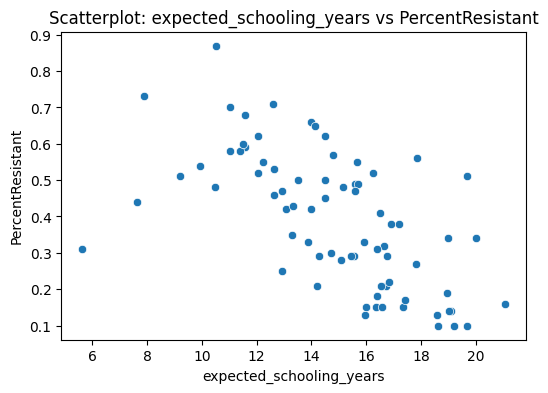

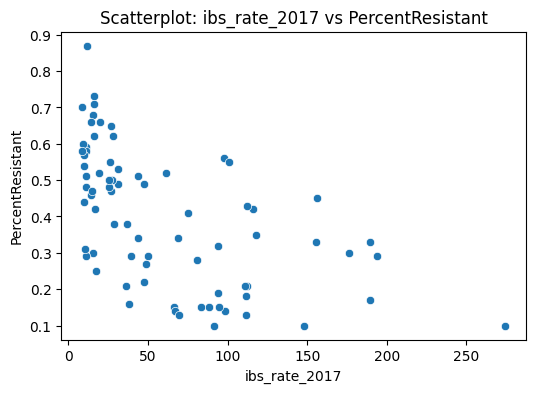

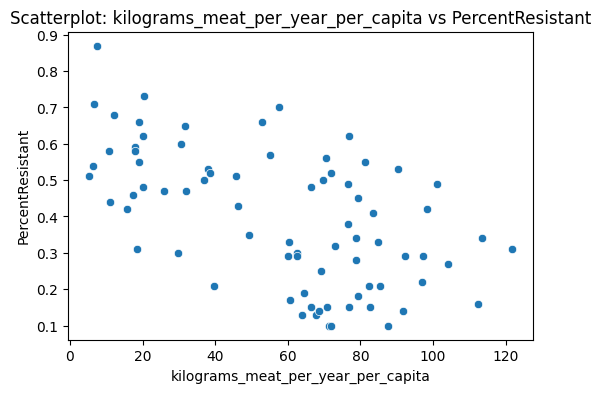

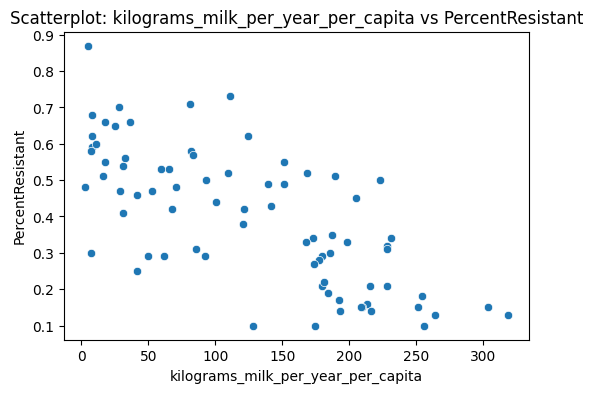

In [4]:
numeric_cols = ['antimicrobial_mg_per_population', 
                'kilograms_eggs_per_year_per_capita',
                'expected_schooling_years', 
                'ibs_rate_2017',
                'kilograms_meat_per_year_per_capita',
                'kilograms_milk_per_year_per_capita']

target = 'PercentResistant'
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[col], y=df[target])
    plt.title(f'Scatterplot: {col} vs {target}')
    plt.xlabel(col)
    plt.ylabel(target)
    plt.show()


In [10]:
#process data
#impute is to fill remaining empty cells with Na
numeric_transformer = Pipeline(steps=[ #first preprocess then put a linear regression model
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer( #allows data to all readable
    transformers=[
        ('num', numeric_transformer, numeric_cols)
    ])

In [11]:
X = df[numeric_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Training samples: {X_train.shape[0]}')
print(f'Testing samples: {X_test.shape[0]}')


Training samples: 62
Testing samples: 16


In [12]:
#linear regression model
linreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
linreg_pipeline.fit(X_train, y_train)

y_pred_linreg = linreg_pipeline.predict(X_test)

print("\nLinear Regression Results:")
print("R^2 Score:", r2_score(y_test, y_pred_linreg))
mse = mean_squared_error(y_test, y_pred_linreg)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)


Linear Regression Results:
R^2 Score: 0.5415654944637118
MSE: 0.011081937867424865
RMSE: 0.10527078354142172


In [14]:
#start of random forest model (decision tree model)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)

print("\nRandom Forest Results:")
print("R^2 Score:", r2_score(y_test, y_pred_rf))
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print("MSE:", mse_rf)
print("RMSE:", rmse_rf)


Random Forest Results:
R^2 Score: 0.27975854178786075
MSE: 0.017410711875000005
RMSE: 0.13194965659295974


In [23]:
#Knn model 
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=5))  # you can try k=3, 5, 7
])

knn_pipeline.fit(X_train, y_train)

y_pred_knn = knn_pipeline.predict(X_test)

print("\nK-Nearest Neighbors Regression Results:")
print("R^2 Score:", r2_score(y_test, y_pred_knn)) #testing
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
y_train_pred_knn = knn_pipeline.predict(X_train)
print("Training R²:", r2_score(y_train, y_train_pred_knn))
print("MSE:", mse_knn)
print("RMSE:", rmse_knn)


K-Nearest Neighbors Regression Results:
R^2 Score: 0.6171210652187964
Training R²: 0.6398059435579555
MSE: 0.009255499999999998
RMSE: 0.09620550919775851


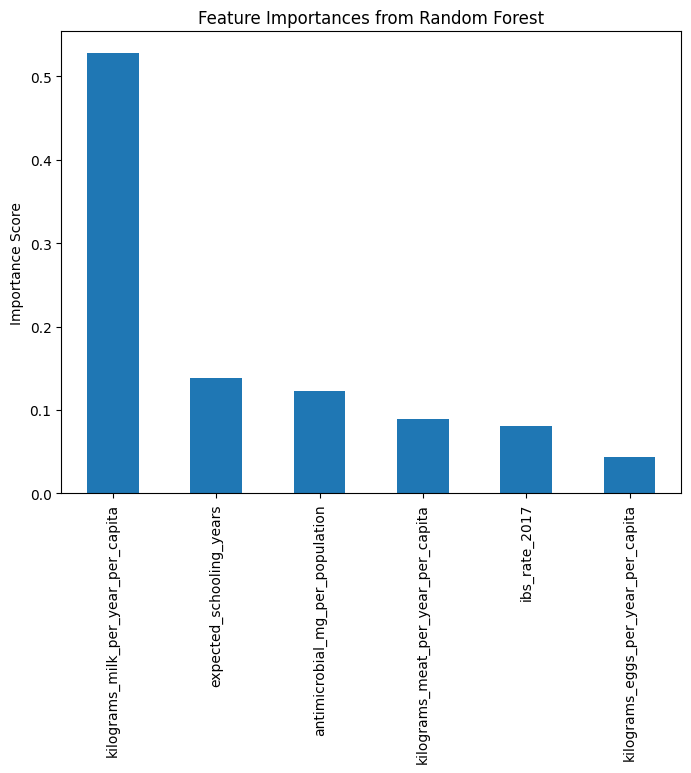

In [18]:
rf_model = rf_pipeline.named_steps['regressor']
feature_importances = pd.Series(rf_model.feature_importances_, index=numeric_cols).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance Score')
plt.show()

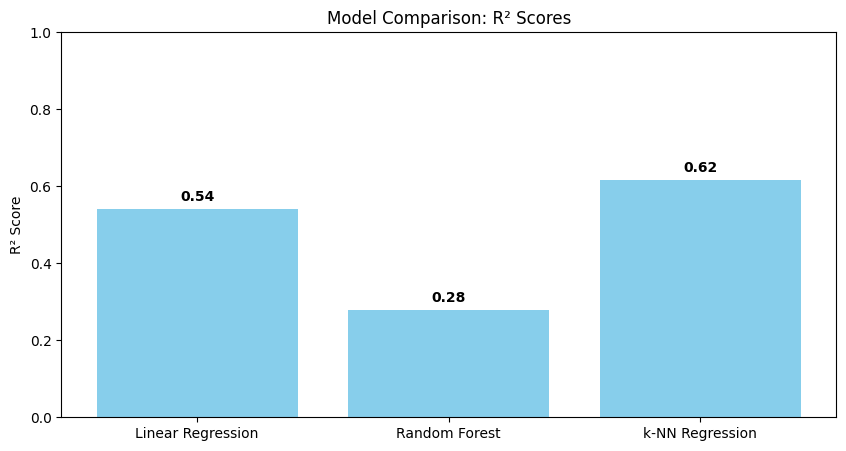

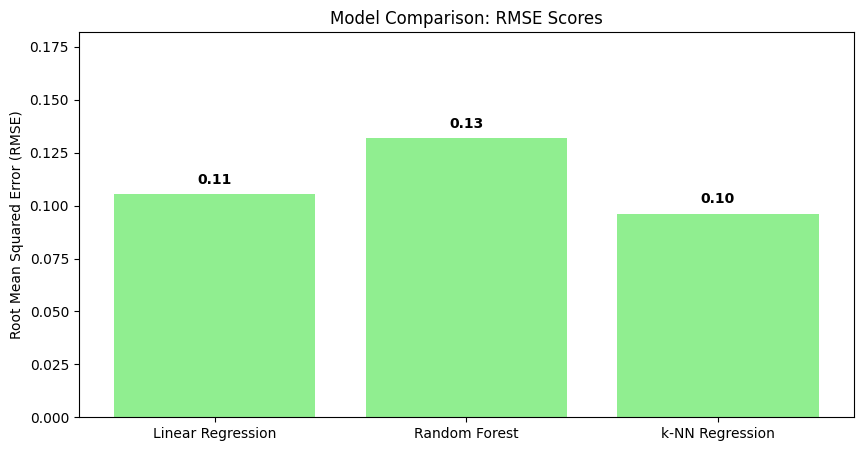

In [19]:
#comparison plot
import matplotlib.pyplot as plt

model_names = ['Linear Regression', 'Random Forest', 'k-NN Regression']
r2_scores = [0.5416, 0.2798, 0.6171]
rmse_scores = [0.1053, 0.1319, 0.0962]

#  plot r^2 scores
plt.figure(figsize=(10, 5))
plt.bar(model_names, r2_scores, color='skyblue')
plt.title('Model Comparison: R² Scores')
plt.ylabel('R² Score')
plt.ylim(0, 1)
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

#Plot root MSE Scores 
plt.figure(figsize=(10, 5))
plt.bar(model_names, rmse_scores, color='lightgreen')
plt.title('Model Comparison: RMSE Scores')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.ylim(0, max(rmse_scores) + 0.05)
for i, v in enumerate(rmse_scores):
    plt.text(i, v + 0.005, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()


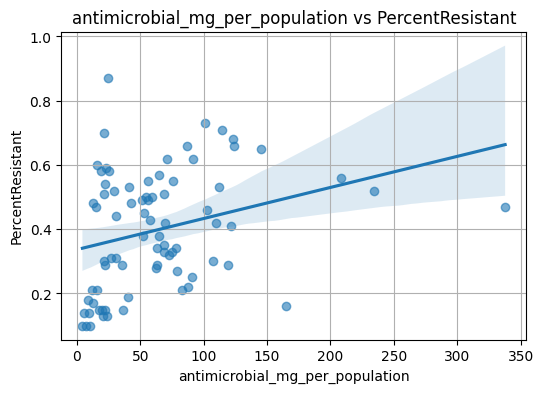

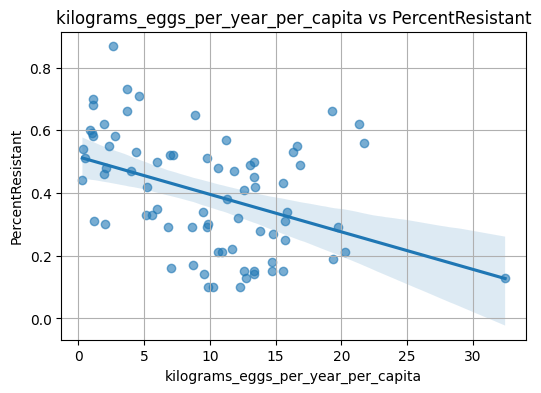

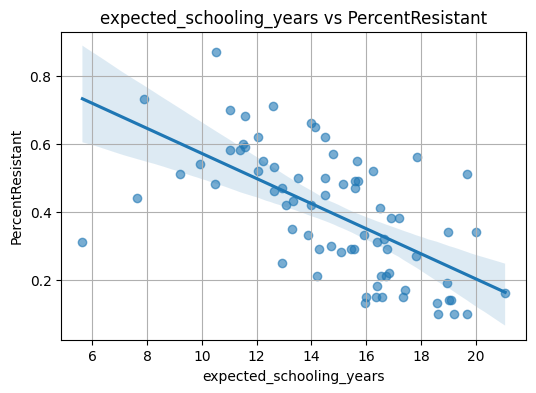

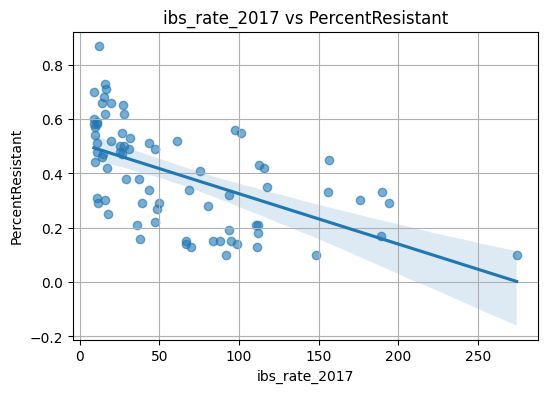

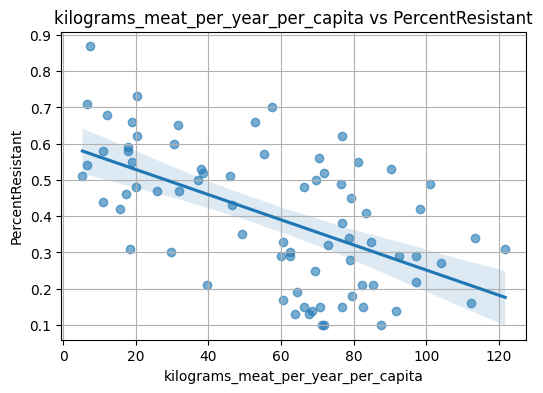

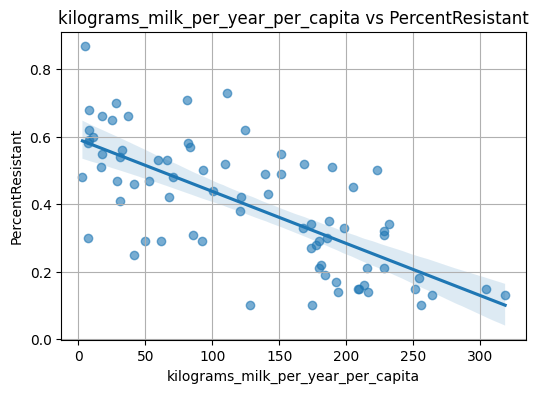

In [21]:
#regression impact
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ['antimicrobial_mg_per_population', 
                'kilograms_eggs_per_year_per_capita',
                'expected_schooling_years', 
                'ibs_rate_2017',
                'kilograms_meat_per_year_per_capita',
                'kilograms_milk_per_year_per_capita']

target = 'PercentResistant'

# For each predictor, plot a scatterplot with regression line
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.regplot(x=df[col], y=df[target], scatter_kws={'alpha':0.6})
    plt.title(f'{col} vs {target}')
    plt.xlabel(col)
    plt.ylabel(target)
    plt.grid(True)
    plt.show()


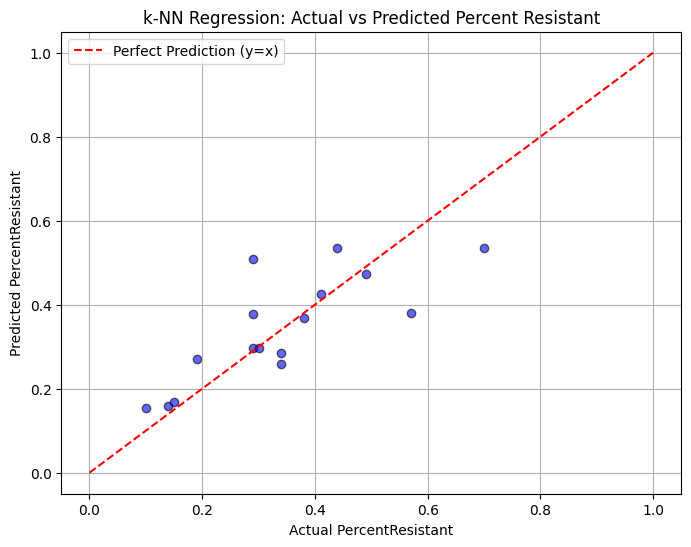

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# plot Actual vs Predicted for k-NN model
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_knn, color='blue', alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], '--r', label='Perfect Prediction (y=x)')
plt.xlabel('Actual PercentResistant')
plt.ylabel('Predicted PercentResistant')
plt.title('k-NN Regression: Actual vs Predicted Percent Resistant')
plt.legend()
plt.grid(True)
plt.show()

#If your points are close to the red dashed line, your k-NN model is predicting resistance rates accurately.

#If your points are widely spread from the line, it indicates larger errors.
